In [1]:
import pandas
import matplotlib.pyplot as plt
from configparser import ConfigParser, ExtendedInterpolation
import json

In [2]:
import random

In [3]:
def include_commit(df):
    #f['Commit'] = [1000]
    df.insert(loc=1, column='Commit', value=1000)
    return df

In [4]:
def load_and_clean(csv):
    df = pandas.read_csv(csv)
    #remove s after values
    selection = df.select_dtypes('object')
    for i in selection.columns:
        df[i] = df[i].str.replace('s', '')
        df[i] = df[i].astype(float)
    df = include_commit(df)
    i = 0
    while i < 10: #user will provide commit number to go back to here
        new_row = []
        for j in df.columns:
            if df[j].dtype == 'float64':
                rand_float = round(random.uniform(0.05, 10),2)
                new_row.append(rand_float)
            elif df[j].name == 'Threads run':
                rand_int = random.randint(100, 251)
                new_row.append(rand_int)
            elif df[j].name == 'Queries performed':
                rand_int = random.randint(500, 1000)
                new_row.append(rand_int)
            elif df[j].name == 'Rows printed to stdout or outfiles':
                rand_int = random.randint(1500, 2100)
                new_row.append(rand_int)
            elif df[j].name == 'Commit':
                rand_int = random.randint(10000, 70000)
                new_row.append(rand_int)
        df.loc[len(df)] = new_row
        df['Threads run'] = df['Threads run'].astype(int)
        df['Queries performed'] = df['Queries performed'].astype(int)
        df['Rows printed to stdout or outfiles'] = df['Rows printed to stdout or outfiles'].astype(int)
        df['Commit'] = df['Commit'].astype(int)
        df['Commit'] = df['Commit'].astype(str)
        i = i + 1
    return df

In [5]:
def plot_all(col):
    if col.name == 'Commit':
        return
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(df['Commit'].values.tolist(), col.values.tolist(), marker='o', linestyle='dashed')
    ax.set_title(f'{col.name}')
    if col.dtype == 'float64':
        ax.set_ylabel('Time(seconds)')
    elif col.name == 'Threads run':
        ax.set_ylabel('Threads')
    elif col.name == 'Queries performed':
        ax.set_ylabel('Queries')
    elif col.name == 'Rows printed to stdout or outfiles':
        ax.set_ylabel('Rows printed')
    ax.set_xlabel('Commit Hash')
    #annotate
    offset = 2
    for x,y in zip(df['Commit'].values.tolist(), col.values.tolist()):
        ax.annotate(f'{y}', (x,y), color='green', textcoords ='offset points',  xytext =(offset, offset))
    plt.show()

In [ ]:
def placeholder_points(columns_to_plot, some_list):
    while len(some_list) < len(columns_to_plot):
        some_list.append(-1)

In [102]:
def plot_points(ax, columns_to_plot, marker, line_type, line_colors, df, annotations, text_color):
    if len(columns_to_plot) == len(line_colors) == len(line_type) == len(marker):
        for col, mark, l_type, l_color in zip(columns_to_plot, marker, line_type, line_colors):
            ax.plot(df['Commit'].values.tolist(), df[col].values.tolist(), marker=mark, linestyle=l_type, color = l_color)
            if annotations == True:
                for x, y in zip(df['Commit'].values.tolist(), df[col].values.tolist()): #This is a for loop for the marker and linestyle
                    ax.annotate(f'{y}', (x,y), color='green', textcoords ='offset points',  xytext =(offset, offset))
    elif 
    else:
        for col in columns_to_plot:
            ax.plot(df['Commit'].values.tolist(), df[col].values.tolist())
            if annotations == True:
                for x, y in zip(df['Commit'].values.tolist(), df[col].values.tolist()): #This is a for loop for the marker and linestyle
                    ax.annotate(f'{y}', (x,y), color='green', textcoords ='offset points',  xytext =(offset, offset))
    return ax

In [103]:
def generate_graph(df, columns_to_plot, line_colors, graph_title, dimensions, line_type, marker, x_label, y_label, annotations, offset, text_color):
    fig, ax = plt.subplots(figsize=(dimensions[0], dimensions[1]))
    offset = 2
    ax = plot_points(ax, columns_to_plot, marker, line_type, line_colors, df, annotations, text_color)

    if len(columns_to_plot) >= 2:
        ax.legend(columns_to_plot)
    ax.set_title(graph_title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.show()

In [104]:
def config_checks(columns_to_plot, line_colors, line_type, marker, text_color):
    if len(columns_to_plot) == len(line_colors) == len(line_type) == len(marker):
        return 1
    if len(line_colors) == 0 and len(line_type) == 0 and len(marker) == 0:
        return 1
    print("List leng")

## Main

In [105]:
parser = ConfigParser(interpolation=ExtendedInterpolation())
parser.read("configs/graph_config.ini") #user will provide this at command line

path_to_csv = parser.get('data', 'path_to_csv')
png = parser.get('data', 'save_to')

columns_to_plot = json.loads(parser.get('general', 'columns_to_plot'))
line_colors = json.loads(parser.get('general', 'line_colors'))
graph_title = parser.get('general', 'graph_title')
dimensions = json.loads(parser.get('general', 'dimension'))

line_type = json.loads(parser.get('line', 'line_type'))
marker = json.loads(parser.get('line', 'marker'))

x_label = parser.get('axes', 'x_label')
y_label = parser.get('axes', 'y_label')

annotations = parser.getboolean('annotations', 'annotations')
offset = parser.getint('annotations', 'offset')
text_color = json.loads(parser.get('annotations', 'text_color'))

#azimuth_list = json.loads(parser.get('azimuth_polar_list', 'azimuth_list'))

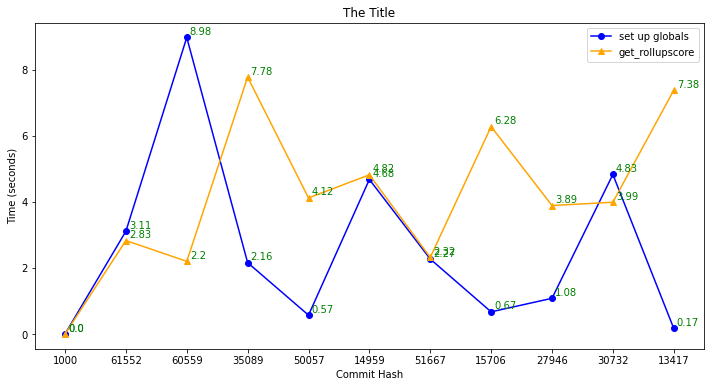

In [106]:
if not config_checks(columns_to_plot, colors, line_type, marker):
    exit()
df = load_and_clean(path_to_csv)
generate_graph(df, columns_to_plot, line_colors, graph_title, dimensions, line_type, marker, x_label, y_label, annotations, offset)

,set up globals,Commit,set up intermediate databases,thread pool,open directories,attach index,xattrprep,addqueryfuncs,get_rollupscore,descend,...,free work,output timestamps,aggregate into final databases,print aggregated results,clean up globals,Threads run,Queries performed,Rows printed to stdout or outfiles,Total Thread Time (not including main),Real time (main)
0,0.00,1000,0.00,0.06,0.00,0.02,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,192,960,1764,0.05,0.06
1,7.33,59954,3.31,9.20,1.02,0.26,8.56,1.13,9.21,1.63,...,4.41,3.11,7.89,5.84,0.09,165,699,1875,7.10,8.52
2,4.86,62273,3.41,0.13,9.94,3.09,8.01,9.62,5.65,6.94,...,7.49,9.14,2.48,1.02,8.86,213,994,1562,8.35,6.09
3,4.30,62997,5.95,8.65,5.82,8.56,9.71,0.29,9.31,5.47,...,2.83,7.68,8.65,0.09,6.03,195,661,1927,5.52,6.93
4,0.66,57313,6.65,4.03,4.83,1.32,6.59,3.23,0.15,1.81,...,3.20,6.00,8.99,3.47,5.79,232,856,1870,2.78,5.17
5,5.39,26673,4.99,1.72,6.57,2.80,3.93,6.35,4.49,6.58,...,3.19,9.49,2.43,8.55,5.67,139,810,1622,8.33,3.48
6,9.05,11518,3.31,3.34,8.80,6.76,4.78,7.49,5.99,2.99,...,1.39,9.75,4.39,7.76,1.66,111,771,1903,5.33,0.84
7,4.52,14660,6.53,9.24,7.13,4.16,2.69,8.50,6.39,9.63,...,5.67,9.96,9.60,0.08,6.51,211,970,1873,3.31,6.47
8,7.63,69738,1.03,0.61,5.85,4.06,8.35,1.52,0.79,7.27,...,2.16,5.01,4.17,7.17,1.94,137,671,2040,2.04,9.60
9,2.71,52377,2.17,8.80,4.45,3.30,6.26,5.70,1.32,4.03,...,4.80,7.85,2.23,9.41,3.61,141,641,1717,2.96,7.71


In [21]:
df = load_and_clean('gufi_query.csv')
df.apply(plot)

For i in range number of commits_back:
    using code at commit i, run gufi_query 's 'e ...

In [ ]:
df.plot(figsize=(32, 24), subplots=True, layout=(5,10))